This notebook contains the code for data wrangling and Model building.

In [1]:
#importing libararies
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
#from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta
from scipy.special import boxcox1p
from scipy import stats
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#reading the final cleaned file from the previous notebook
df = pd.read_csv('/content/drive/MyDrive/final_df.csv')
df.shape

(133089, 104)

In [4]:
df.head()

,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_pay_mean,mcare_pay_median,...,ownership_PRIVATE (FOR PROFIT)_mode_y,ownership_PRIVATE (NOT FOR PROFIT)_mode_y,ownership_STATE_mode_y,ownership_TRIBAL_mode_y,urban_rural_URBAN_mode_y,teaching_YES_mode_y,hospital_count,avg_income_2020,population_estimate_2020,Life Expectancy
0,10180,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,8.0,47740.0,173185.0,77.864183
1,10420,2018,Inpatient,breast reconstruction,8.0,19937.08375,16147.330,5692.86,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,11.0,53252.0,701449.0,76.567472
2,10500,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5,0.0,0.0,0.0,1.0,0.0,4.0,45593.0,145206.0,76.615437
3,10540,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.5,0.0,0.0,1.0,0.5,2.0,42653.0,131054.0,79.088550
4,10580,2018,Inpatient,breast reconstruction,4.0,14837.26000,10420.675,4474.06,NaN,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,17.0,58601.0,878550.0,80.327023


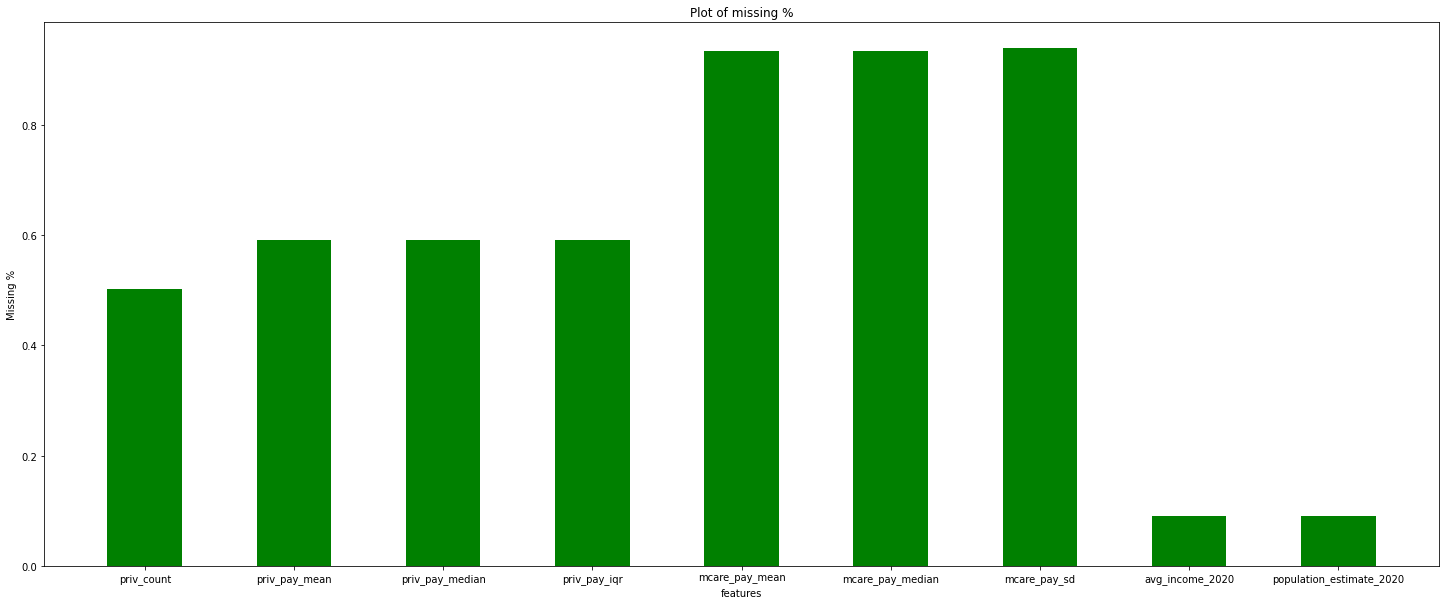

In [5]:
#code to plot missing values
m = []
idx = []
x = []

for id, i in enumerate(df.columns):
  percent = df[i].isnull().sum()/len(df)
  if percent > 0.025:
    idx.append(id)
    m.append(percent)

for i in idx:
  x.append(list(df.columns)[i])

plt.figure(figsize=(25,10))
plt.bar(x, m, color ='green', width = 0.5)
plt.xlabel("features")
plt.ylabel("Missing %")
plt.title("Plot of missing %")
plt.show()

In [6]:
def plot_choropleth(df, i):
  state_code = pd.read_csv('/content/drive/MyDrive/us-state-ansi-fips.csv')
  df1 = df.groupby(by = 'FIPS State Code')[i].mean()
  a = state_code.merge(df1.to_frame(), left_on = ' st', right_on= 'FIPS State Code')
  a[' stusps'] = a[' stusps'].apply(lambda x: x.lstrip())

  fig = px.choropleth(a,
                    locations=' stusps',
                    color=i,
                    color_continuous_scale='spectral_r',
                    hover_name='stname',
                    locationmode='USA-states',
                    scope='usa')

  fig.show()

In [7]:
# plot_choropleth(df, 'avg_income_2020')

In [8]:
# plot_choropleth(df, 'Life Expectancy')

In [9]:
# plot_choropleth(df, 'hospital_count')

In [10]:
#imputing hte lat long value for MSA 42540 ( checked online)
df.loc[df.msa == 42540, 'lat'] = 41.408970
df.loc[df.msa == 42540, 'lon'] = -75.662415

In [11]:
# Adding Lat/Long to into haversine distance

from math import radians, cos, sin, asin, sqrt

def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

df['harvesine_distance'] = [single_pt_haversine(x, y) for x, y in zip(df.lat, df.lon)]
# Geohash.encode(df_valid.iloc[0, list(df_valid.columns).index('lat')], df_valid.iloc[0, list(df_valid.columns).index('lon')])

In [12]:
# cehck for missing value of haversine distance
df[pd.isna(df['harvesine_distance'])][['msa', 'lat', 'lon', 'CBSA_NAME', 'FIPS State Code']]

,msa,lat,lon,CBSA_NAME,FIPS State Code


In [13]:
# check for target missing and target >0
df = df[ (df.priv_pay_mean >0) | (df['priv_pay_mean'].isna())]

In [14]:
# getting categories for site
df.site.value_counts()

Outpatient    60982
Inpatient     60972
ASC           10984
Name: site, dtype: int64

In [15]:
#Since ASC has to be less than outpatient and Inpatient, Assigning  weight 0 to ASC and 1 to other groups.
df['site_weight']  = 1
df.loc[df['site'] == 'ASC', 'site_weight'] = 0
df.site_weight.value_counts()

<ipython-input-15-9a53d6b92b58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['site_weight']  = 1


1    121954
0     10984
Name: site_weight, dtype: int64

In [16]:
#Check for ASC payment > Inpatient payment
df_inpatient = df[ (df['site'] == 'Inpatient') & (~df['priv_pay_mean'].isna())].groupby(['msa','group','year'])['priv_pay_mean'].min().reset_index()
df_inpatient.shape

(19996, 4)

In [17]:
df_inpatient.columns = ['msa', 'group', 'year', 'min_inpatient_pay']
df_inpatient.head()

,msa,group,year,min_inpatient_pay
0,10180,ankle_fix,2018,50892.66000
1,10180,ant_cerv_fusion,2018,71236.01333
2,10180,ant_cerv_fusion,2019,62690.41000
3,10180,ant_cerv_fusion,2020,78303.19500
4,10180,ant_tls_fusion,2018,35398.22000


In [18]:
df = pd.merge(df, df_inpatient, on = ['msa', 'group', 'year'], how='left')
df[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC')].shape
## 215 rows have ASC > Inpatient

(215, 107)

In [19]:
# final check for ASC > Inaptient in given datset
df.loc[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC'), 'priv_pay_mean'] = \
df.loc[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC'), 'min_inpatient_pay']

df[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC')].shape

(0, 107)

In [20]:
df[df.site == 'ASC'].groupby(['msa', 'group', 'year']).agg({'priv_pay_mean':'sum'}).reset_index()

,msa,group,year,priv_pay_mean
0,10180,ankle_fix,2018,2800.593333
1,10180,ankle_fix,2019,0.000000
2,10180,ankle_fix,2020,0.000000
3,10180,ant_cerv_fusion,2018,11646.950000
4,10180,ant_cerv_fusion,2019,11715.940000
...,...,...,...,...
10979,49740,tha,2019,0.000000
10980,49740,tha,2020,25579.730000
10981,49740,tka,2018,0.000000
10982,49740,tka,2019,0.000000


#### Addiing procedure level cluster data

In [21]:
df_cluster = pd.read_csv('/content/drive/MyDrive/discharge_physpec_categorised.csv')
df_cluster = df_cluster[~((df_cluster.group == 'lung ablation') & (df_cluster.phy_spec == 'HOSPITALIST\xa0(HOS)'))]
df_cluster = df_cluster[['group', 'pat_cost', 'discharge_to_home_pct', 'phy_spec',
       'IP_pct', 'discharge_category_dbscan', 'discharge_category_kmedoids']]
df_cluster.drop_duplicates(inplace = True)
df_cluster.reset_index(inplace = True, drop = True)
print(df_cluster.shape)
print(df_cluster.group.nunique())

(49, 7)
49


In [22]:
df_cluster.head()

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct,discharge_category_dbscan,discharge_category_kmedoids
0,ankle_fix,16741.5136,0.621714,ORTHOPEDIC SURGERY (ORS),0.542798,0,0
1,ant_cerv_fusion,18848.1697,0.846973,NEUROLOGICAL SURGERY (NS),0.575495,-1,3
2,ant_tls_fusion,49478.1242,0.596666,ORTHOPEDIC SURGERY (ORS),0.983543,0,2
3,bariatric,14585.5550,0.945035,GENERAL SURGERY (GS),0.911311,1,3
4,breast reconstruction,13690.8043,0.929970,PLASTIC SURGERY (PS),0.246127,-1,0


In [23]:
print(df.shape)
print(df.group.nunique())

(132938, 107)
51


In [24]:
print(pd.merge(df, df_cluster, on = 'group', how = 'inner').shape)
print(pd.merge(df, df_cluster, on = 'group', how = 'inner')['group'].nunique())

(129275, 113)
49


In [25]:
# creating copy of the medical dataset and selecting the variables
df_temp = df_cluster.copy()
df_temp.columns = ['group_procedure', 'pat_cost', 'discharge_to_home_pct', 'phy_spec',
       'IP_pct', 'discharge_category_dbscan', 'discharge_category_kmedoids']

df_temp = df_temp[['group_procedure', 'pat_cost', 'discharge_to_home_pct', 'phy_spec',
       'IP_pct', 'discharge_category_dbscan', 'discharge_category_kmedoids']]

df_temp = df_temp[['group_procedure']]

In [26]:
df_temp.drop_duplicates(inplace = True)
df_temp.sort_values(by = 'group_procedure', inplace = True)
df_temp.reset_index(inplace = True, drop = True)
df_temp.shape

(49, 1)

In [27]:
df_temp2 = df.copy()
df_temp2 = df_temp2[['group']]
df_temp2.drop_duplicates(inplace = True)
df_temp2.drop_duplicates(inplace = True)
df_temp2.sort_values(by = 'group', inplace = True)
df_temp2.reset_index(inplace = True, drop = True)
df_temp2.shape

(51, 1)

In [28]:
# left joining the procedure dataset with the main dataset
print(df.shape)
df = pd.merge(df, df_cluster, on = 'group', how = 'inner')
print(df.shape)

(132938, 107)
(129275, 113)


In [29]:
df_valid = df[~df['priv_pay_mean'].isna()]
df_valid.shape
## Nearly 60% target is missing

(54183, 113)

In [30]:
df_valid.group.nunique()
# 3 groups and proccedure types missing. Cannot be predicted.

48

In [31]:
def get_data_threshold(df, var, thres):
  print('There are {} rows and {} unique groups using {} as theshold'.format( df[df[var] > thres].shape[0], 
                                                                             df[df[var] > thres].group.nunique(), thres ) )

In [32]:
get_data_threshold(df_valid, 'priv_count', 20)
get_data_threshold(df_valid, 'priv_count', 25)
get_data_threshold(df_valid, 'priv_count', 30)
get_data_threshold(df_valid, 'priv_count', 35)
get_data_threshold(df_valid, 'priv_count', 40)
get_data_threshold(df_valid, 'priv_count', 50)
get_data_threshold(df_valid, 'priv_count', 60)

There are 8087 rows and 41 unique groups using 20 as theshold
There are 6841 rows and 39 unique groups using 25 as theshold
There are 5921 rows and 39 unique groups using 30 as theshold
There are 5234 rows and 39 unique groups using 35 as theshold
There are 4680 rows and 38 unique groups using 40 as theshold
There are 3843 rows and 36 unique groups using 50 as theshold
There are 3295 rows and 31 unique groups using 60 as theshold


In [33]:
rows, groups  = [], []
var = 'priv_count'
for i in range(1,101):
  rows.append(df_valid[df_valid[var] > i].shape[0])
  groups.append(df_valid[df_valid[var] > i].group.nunique())

index  = np.arange(1,101,1)

In [34]:
df_thres = pd.DataFrame()

df_thres['Threshold'] = index
df_thres['Groups'] = groups
df_thres['Rows'] = rows
df_thres['All_Groups'] = df_valid.group.nunique()


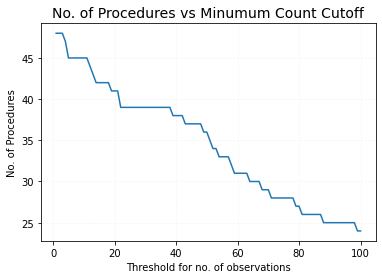

<Figure size 432x288 with 0 Axes>

In [35]:
sns.lineplot(data=df_thres, x="Threshold", y="Groups")
plt.xlabel('Threshold for no. of observations')
plt.ylabel('No. of Procedures')
plt.title('No. of Procedures vs Minumum Count Cutoff', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.1)
plt.show() 
plt.savefig('Cutoff_1.png')

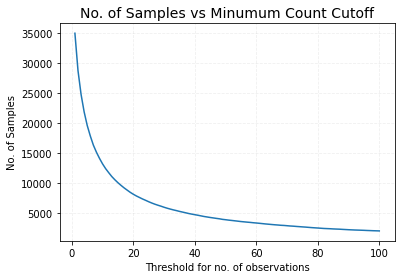

<Figure size 432x288 with 0 Axes>

In [36]:
sns.lineplot(data=df_thres, x="Threshold", y="Rows")
plt.xlabel('Threshold for no. of observations')
plt.ylabel('No. of Samples')
plt.title('No. of Samples vs Minumum Count Cutoff', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 
plt.savefig('Cutoff_2.png')

In [37]:
#slicing the data at 30 theshold
df_valid = df_valid[df['priv_count'] > 30]
df_valid.shape

<ipython-input-37-0b494451592f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_valid = df_valid[df['priv_count'] > 30]


(5921, 113)

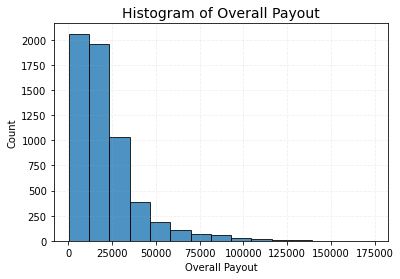

In [38]:
plt.hist(df_valid.priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Overall Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

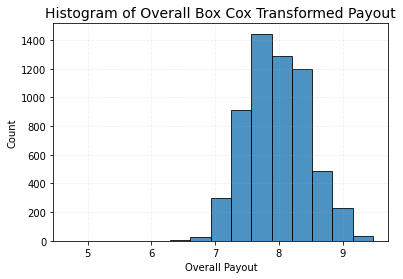

In [39]:
df_valid['bc_priv_pay_mean'] = stats.boxcox(df_valid['priv_pay_mean'])[0]

plt.hist(df_valid.bc_priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Overall Box Cox Transformed Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

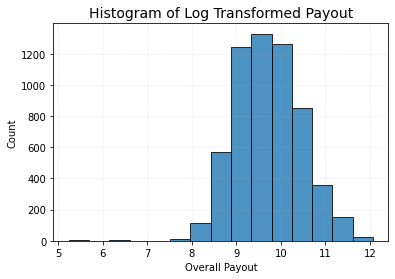

In [40]:
df_valid['log_priv_pay_mean'] = np.log(df_valid['priv_pay_mean'])

plt.hist(df_valid.log_priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Log Transformed Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

In [43]:
# numeric features

num_features = [
'site_weight',
'year',  
'priv_count', 
'ownership_FEDERAL_median','ownership_HOSPITAL DISTRICT OR AUTHORITY_median','ownership_LOCAL_median', 'ownership_OTHER (SPECIFY)_median',
'ownership_PHYSICIAN OWNERSHIP_median', 'ownership_PRIVATE (FOR PROFIT)_median', 'ownership_PRIVATE (NOT FOR PROFIT)_median', 'ownership_STATE_median',
'ownership_TRIBAL_median', 'urban_rural_URBAN_median',
'teaching_YES_median',
'hospital_count', 
'avg_income_2020',
'population_estimate_2020', 
'Life Expectancy', 
'harvesine_distance',
'Covid_payment_median', 
'beds_grp_median','beds_grp_greater_500_median'
]
len(num_features)

22

In [44]:
# ohehot encoding and terget encoding features
ohe_features = ['site']
tar_enc_features = ['group', 'msa']

In [45]:
all_features = num_features + ohe_features + tar_enc_features
len(all_features)

25

In [46]:
df.shape

(129275, 113)

### Data Visualization

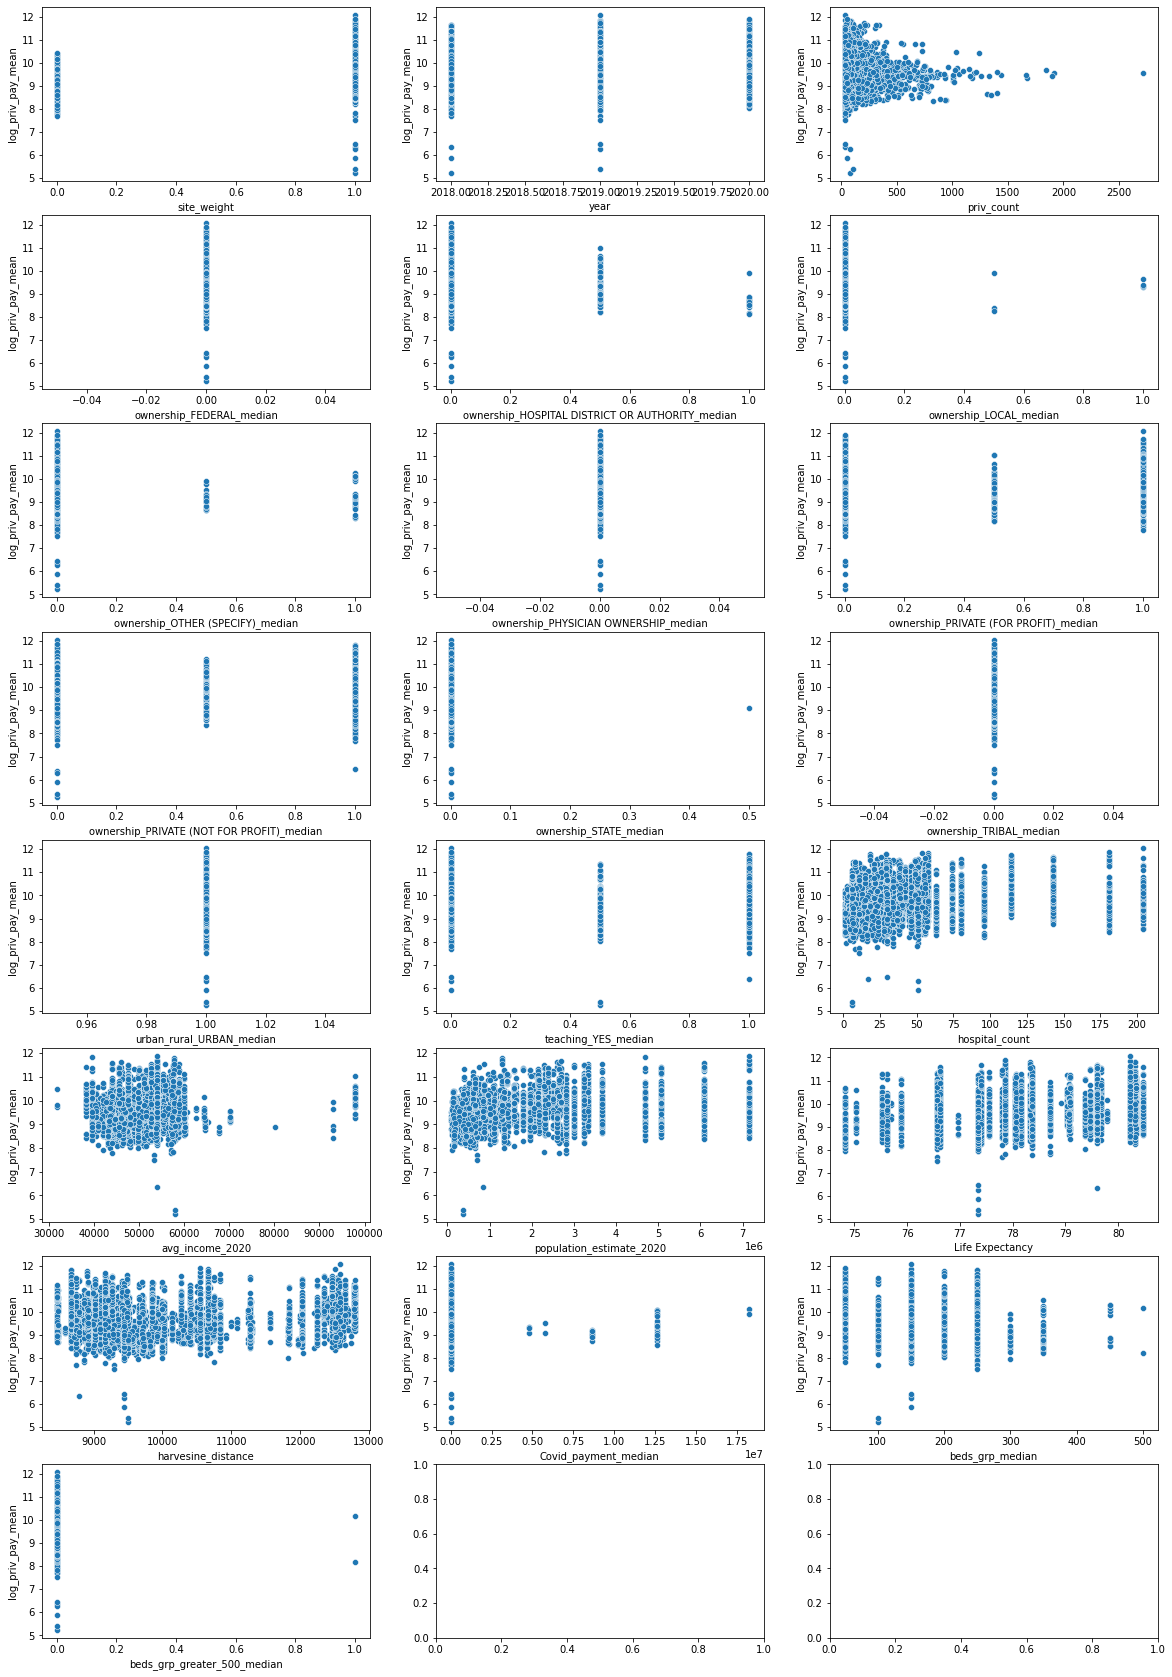

In [47]:
### Your code here
fig, ax = plt.subplots(8, 3, figsize = (20,30))

for col, subplot in zip(num_features, ax.flatten()):
    sns.scatterplot(x=col, y=df_valid['log_priv_pay_mean'], data = df_valid[num_features] , ax= subplot)
plt.show(fig)

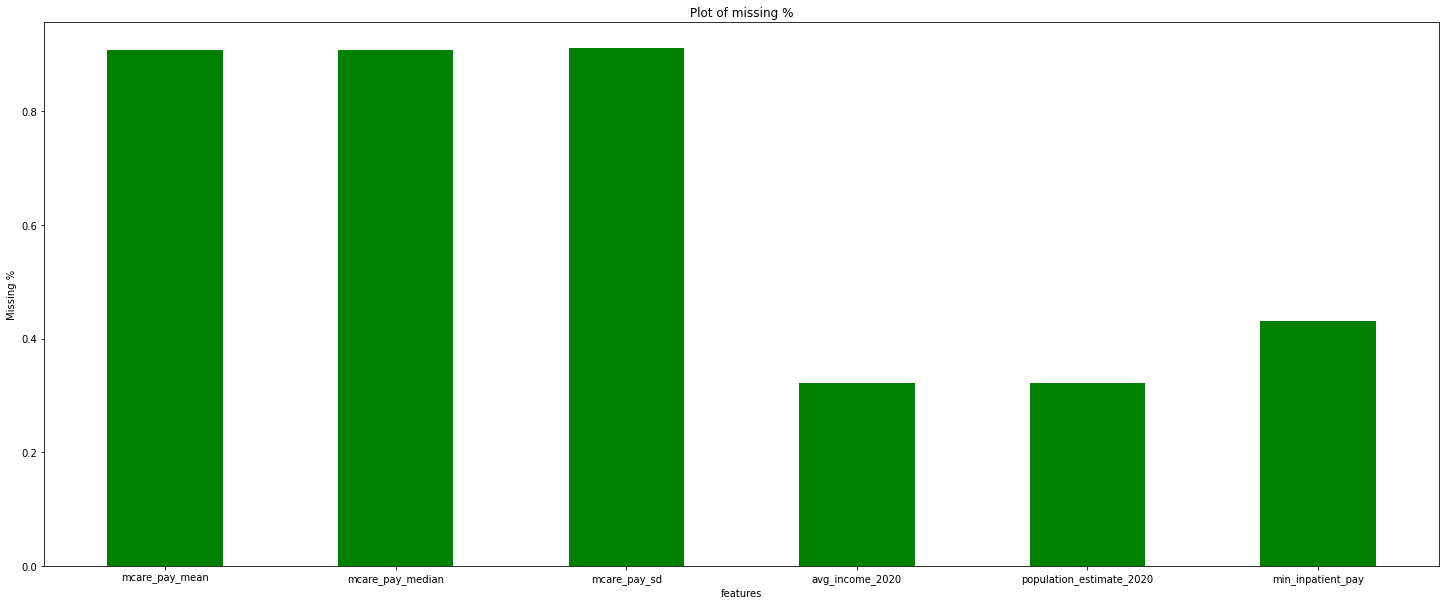

In [48]:
#missing value graph for new features
m = []
idx = []
x = []

for id, i in enumerate(df_valid.columns):
  percent = df_valid[i].isnull().sum()/len(df_valid)
  if percent > 0.01:
    idx.append(id)
    m.append(percent)

for i in idx:
  x.append(list(df_valid.columns)[i])

plt.figure(figsize=(25,10))
plt.bar(x, m, color ='green', width = 0.5)
plt.xlabel("features")
plt.ylabel("Missing %")
plt.title("Plot of missing %")
plt.show()

In [49]:
df_valid[df_valid['population_estimate_2020'].isnull()][['msa', 'population_estimate_2020', 'FIPS State Code']]

,msa,population_estimate_2020,FIPS State Code
89,19124,NaN,48
261,35614,NaN,34
496,19124,NaN,48
667,35614,NaN,34
902,19124,NaN,48
...,...,...,...
128595,23104,NaN,48
128843,47664,NaN,26
128957,19124,NaN,48
129129,35614,NaN,34


In [50]:
# removing null values in teaching_YES_mode_y variable
df_valid = df_valid[~df_valid['teaching_YES_mode_y'].isnull()]

In [51]:
# imputing missing values in avg_income_2020 and avg_income_2020
df_valid['population_estimate_2020'] = df_valid['population_estimate_2020'].fillna(df_valid['avg_income_2020'].mean())
df_valid['avg_income_2020'] = df_valid['avg_income_2020'].fillna(df_valid['avg_income_2020'].mean())

<ipython-input-51-ba230b61d418>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['population_estimate_2020'] = df_valid['population_estimate_2020'].fillna(df_valid['avg_income_2020'].mean())
<ipython-input-51-ba230b61d418>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['avg_income_2020'] = df_valid['avg_income_2020'].fillna(df_valid['avg_income_2020'].mean())


In [53]:
#check for dataframe shape
df_valid.shape

(5885, 115)

### Data Split

In [54]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
!pip install category_encoders
from category_encoders import TargetEncoder
import time
from datetime import timedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
# final check for missing values
df_valid[all_features].isnull().sum()

site_weight                                        0
year                                               0
priv_count                                         0
ownership_FEDERAL_median                           0
ownership_HOSPITAL DISTRICT OR AUTHORITY_median    0
ownership_LOCAL_median                             0
ownership_OTHER (SPECIFY)_median                   0
ownership_PHYSICIAN OWNERSHIP_median               0
ownership_PRIVATE (FOR PROFIT)_median              0
ownership_PRIVATE (NOT FOR PROFIT)_median          0
ownership_STATE_median                             0
ownership_TRIBAL_median                            0
urban_rural_URBAN_median                           0
teaching_YES_median                                0
hospital_count                                     0
avg_income_2020                                    0
population_estimate_2020                           0
Life Expectancy                                    0
harvesine_distance                            

In [57]:
df_asc = df_valid.groupby(['msa', 'group', 'year']).agg({'priv_pay_mean':'sum'}).reset_index()
df_asc.shape

df_asc = df_valid[df_valid.site == 'ASC'].groupby(['msa', 'group', 'year']).agg({'priv_pay_mean':'sum'}).reset_index()
df_asc.shape

df_in = df_valid[df_valid.site == 'Inpatient'].groupby(['msa', 'group', 'year']).agg({'priv_pay_mean':'sum'}).reset_index()
df_in.shape

pd.merge(df_asc, df_in, on = ['msa', 'group', 'year'] , how = 'inner').shape

(81, 5)

In [58]:
df_asc = df_valid[df_valid.site == 'ASC'].groupby(['msa', 'group', 'year']).agg({'priv_pay_mean':'sum'}).reset_index()
df_asc.shape

(612, 4)

In [59]:
df_in = df_valid[df_valid.site == 'Inpatient'].groupby(['msa', 'group', 'year']).agg({'priv_pay_mean':'sum'}).reset_index()
df_in.shape

(1438, 4)

In [60]:
pd.merge(df_asc, df_in, on = ['msa', 'group', 'year'] , how = 'inner').shape

(81, 5)

In [61]:
# seperating target variable into new dataframe
df_valid_X = df_valid[all_features]
df_valid_y = df_valid['log_priv_pay_mean']

In [62]:
# Train, Validation and Test split
df_valid_X_dev, df_valid_X_test, df_valid_y_dev, df_valid_y_test = train_test_split(df_valid_X, df_valid_y, test_size=0.05, random_state=0)
df_valid_X_train, df_valid_X_val, df_valid_y_train, df_valid_y_val = train_test_split(df_valid_X_dev, df_valid_y_dev, test_size=0.07, random_state=0)

In [63]:
print(df_valid.shape)
print(df_valid_X_train.shape)
print(df_valid_X_val.shape)
print(df_valid_X_test.shape)

(5885, 115)
(5198, 25)
(392, 25)
(295, 25)


## Model Building

### Linear Regression

In [66]:
# #code here
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown = "ignore"), tar_enc_features),
                                      remainder = 'passthrough'
                                     )

pipe_lr_pure = make_pipeline(preprocess, LinearRegression())
pipe_fit_lr_pure = pipe_lr_pure.fit(df_valid_X_train, df_valid_y_train)

In [67]:
pipe_fit_lr_pure.score(df_valid_X_val, df_valid_y_val)

0.7942131011898708

In [68]:
pipe_fit_lr_pure.score(df_valid_X_test, df_valid_y_test)

0.736177961594517

In [70]:
# custom function to calculte MAPE
def mape(pred, actual):
  mape = 0
  for (p, a) in zip(pred, actual):
     mape += abs(p-a)/a
  return mape/len(pred) 

In [71]:
# MAPE of val dataset
mape(np.exp(pipe_fit_lr_pure.predict(df_valid_X_val)), np.exp(df_valid_y_val))

0.2755212753717375

In [72]:
# MAPE of Test dataset
mape(np.exp(pipe_fit_lr_pure.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.2907541316791375

In [73]:
pipe_fit_lr_pure.named_steps['linearregression'].coef_

array([ 1.45035657e-01,  3.63652207e-02,  1.41722120e-02,  2.49800181e-16,
       -1.65446532e-02,  6.79130659e-03, -1.20960938e-02, -2.77555756e-17,
        2.77984789e-02,  1.89619759e-02, -5.93332285e-04, -5.37764278e-17,
        0.00000000e+00, -9.78750199e-03, -2.22545837e-03,  1.48633680e-02,
        1.04407149e-02,  1.16447904e-01,  1.77182478e-02, -2.96485821e-03,
       -3.60912603e-02,  7.02889398e-03, -4.41796843e-02,  1.62552517e-01,
       -1.18372832e-01,  8.32167665e-01,  3.75128457e-07])

In [74]:
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names 

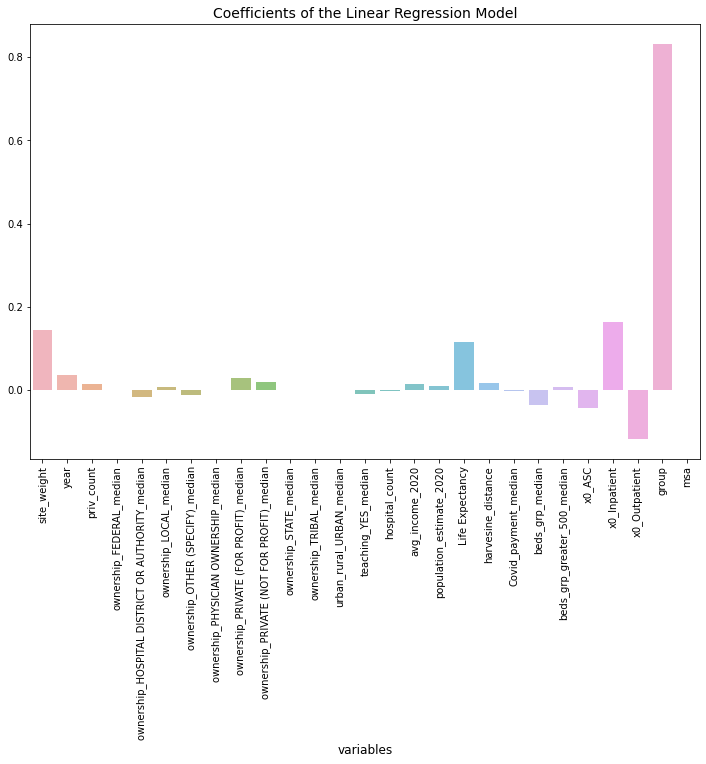

In [75]:
### Your code here
plt.figure(figsize=(12,8))
ax = sns.barplot(x = feature_names, y = pipe_fit_lr_pure.named_steps['linearregression'].coef_, alpha=0.7)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("variables", fontsize = 12)
plt.title("Coefficients of the Linear Regression Model", fontsize=14)
#plt.plot(X_test[:,[1]].reshape(20,), ridge_yhat, color = 'red')
#sns.set_style('ticks')
plt.show(fig)

### Decision Tree

In [76]:
from sklearn.tree import DecisionTreeRegressor

In [77]:
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown = "ignore"), tar_enc_features),
                                      remainder = 'passthrough'
                                     )

pipe_dt_pure = make_pipeline(preprocess, DecisionTreeRegressor())
pipe_fit_dt_pure = pipe_dt_pure.fit(df_valid_X_train, df_valid_y_train)

In [78]:
pipe_fit_dt_pure.score(df_valid_X_val, df_valid_y_val)

0.8312781427026517

In [79]:
pipe_fit_dt_pure.score(df_valid_X_test, df_valid_y_test)

0.868699502291507

In [85]:
# MAPE of Val dataset
mape(np.exp(pipe_fit_dt_pure.predict(df_valid_X_val)), np.exp(df_valid_y_val))

0.24382303030141933

In [86]:
# MAPE of Test dataset
mape(np.exp(pipe_fit_dt_pure.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.1956106683936638

Text(0, 0.5, 'Feature Importance')

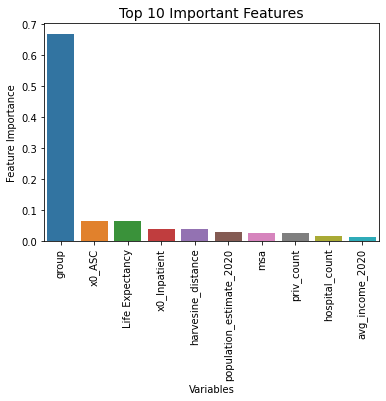

In [84]:
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names + te_feature_names 

feat_imps = zip(feature_names, pipe_fit_dt_pure.named_steps['decisiontreeregressor'].feature_importances_)
feats, imps = zip(*(sorted(list(filter( lambda x : x[1]!=0 , feat_imps)), key = lambda x : x[1] , reverse=True)))
ax = sns.barplot( list(feats)[:10], list(imps)[:10])
ax.tick_params(axis='x', rotation = 90)
plt.title("Top 10 Important Features", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Feature Importance")

#### Elasticnet Regression with CV

In [87]:
# Dev and Test Split 
df_valid_X_dev, df_valid_X_test, df_valid_y_dev, df_valid_y_test = train_test_split(df_valid_X, df_valid_y, test_size=0.20, random_state=80)

In [88]:
param_grid = {
              'alpha': np.linspace(0.01, 1, 20),
              'l1_ratio':np.linspace(0.01, 1, 20)
              }
param_grid

{'alpha': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
        0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
        0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
        0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
 'l1_ratio': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
        0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
        0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
        0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])}

In [89]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [90]:
from sklearn.linear_model import ElasticNet

pipe_lr = make_pipeline(preprocess,
                    GridSearchCV(ElasticNet(random_state=80),
                                param_grid = param_grid, cv = 10)
                    )

pipe_fit_lr = pipe_lr.fit(df_valid_X_dev, df_valid_y_dev)
grid_search_results_lr = pipe_lr.named_steps["gridsearchcv"]

print(f"Best Score: {grid_search_results_lr.best_score_ :3f}")
print(f"Best alpha: {grid_search_results_lr.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_lr.score(df_valid_X_test, df_valid_y_test) :3f}")
best_tree = grid_search_results_lr.best_estimator_


Best Score: 0.772610
Best alpha: {'alpha': 0.01, 'l1_ratio': 0.16631578947368422}
Performance on Test Dataset is: 0.748613


In [91]:
# MAPE of val dataset
mape(np.exp(pipe_fit_lr.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

0.281544176736016

In [93]:
# MAPE of Test dataset
mape(np.exp(pipe_fit_lr.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.2894109458146199

#### Decision Tree with CV

In [94]:
param_grid = {
              'max_depth': np.arange(6,10,1),
              'max_features':['auto', 'sqrt', 'log2'],
              "ccp_alpha": np.linspace(0., 0.03, 20)
              }
param_grid

{'max_depth': array([6, 7, 8, 9]),
 'max_features': ['auto', 'sqrt', 'log2'],
 'ccp_alpha': array([0.        , 0.00157895, 0.00315789, 0.00473684, 0.00631579,
        0.00789474, 0.00947368, 0.01105263, 0.01263158, 0.01421053,
        0.01578947, 0.01736842, 0.01894737, 0.02052632, 0.02210526,
        0.02368421, 0.02526316, 0.02684211, 0.02842105, 0.03      ])}

In [ ]:
pipe_dt = make_pipeline(preprocess,
                    GridSearchCV(DecisionTreeRegressor(random_state=80),
                                param_grid = param_grid,
                                return_train_score = True, cv = 10)
                    )
pipe_fit_dt = pipe_dt.fit(df_valid_X_dev, df_valid_y_dev)
grid_search_results_dt = pipe_dt.named_steps["gridsearchcv"]

print(f"Best Score: {grid_search_results_dt.best_score_ :3f}")
print(f"Best alpha: {grid_search_results_dt.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_dt.score(df_valid_X_test, df_valid_y_test) :3f}")
best_tree = grid_search_results_dt.best_estimator_

Best Score: 0.835401
Best alpha: {'ccp_alpha': 0.0, 'max_depth': 9, 'max_features': 'auto'}
Performance on Test Dataset is: 0.817986


In [ ]:
# MAPE of val dataset
mape(np.exp(pipe_fit_dt.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

0.18779478057657792

In [ ]:
# MAPE of Test dataset
mape(np.exp(pipe_fit_dt.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.24057386560180574

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'bootstrap': [True], 
              'max_features': ['auto', 'log2'],
              'n_estimators': np.arange(200, 401, 100),
              'max_depth': [6,7,8]
              }
param_grid

{'bootstrap': [True],
 'max_features': ['auto', 'log2'],
 'n_estimators': array([200, 300, 400]),
 'max_depth': [6, 7, 8]}

In [ ]:
pipe_rf = make_pipeline(preprocess,
                    GridSearchCV(RandomForestRegressor(random_state=80, warm_start = True),
                                     param_grid = param_grid
                                     )
                    )
start_time_rf = time.monotonic()
pipe_fit_rf = pipe_rf.fit(df_valid_X_dev, df_valid_y_dev)
end_time_rf = time.monotonic()

print(f"Time taken for Model Selection of Random Forest is : {timedelta(seconds=end_time_rf - start_time_rf)}")

grid_search_results_rf = pipe_fit_rf.named_steps["gridsearchcv"]
print(f"Best Score: {grid_search_results_rf.best_score_ :3f}")
print(f"Best Parameters: {grid_search_results_rf.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_rf.score(df_valid_X_test, df_valid_y_test) :3f}")

Time taken for Model Selection of Random Forest is : 0:03:08.542835
Best Score: 0.856311
Best Parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
Performance on Test Dataset is: 0.853223


In [ ]:
# MAPE of val dataset
mape(np.exp(pipe_fit_rf.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

0.19303114398801488

In [ ]:
# MAPE of Test dataset
mape(np.exp(pipe_fit_rf.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.21725484943812676

####GBM

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
              'n_estimators': np.arange(100, 250, 50),
              'max_depth': [6,7,8],
              'learning_rate' : [.01, .1, .2]
              }

In [ ]:

pipe_gbm = make_pipeline(preprocess,
                    RandomizedSearchCV( GradientBoostingRegressor (random_state=80, warm_start = True),
                                     param_distributions = param_grid, n_jobs = -1, cv = 10
                                     )
                    )

start_time_gbm = time.monotonic()
pipe_fit_gbm = pipe_gbm.fit(df_valid_X_dev, df_valid_y_dev)
end_time_gbm = time.monotonic()

print(f"Time taken for Model Selection of Gradient Boosting Classifier is : {timedelta(seconds=end_time_gbm - start_time_gbm)}") 

Time taken for Model Selection of Gradient Boosting Classifier is : 0:02:49.637310


In [ ]:
rand_search_results_gbm = pipe_fit_gbm.named_steps["randomizedsearchcv"]
print(f"Best Score: {rand_search_results_gbm.best_score_ :3f}")
print(f"Best Parameters: {rand_search_results_gbm.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_gbm.score(df_valid_X_test, df_valid_y_test) :3f}")

Best Score: 0.930564
Best Parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1}
Performance on Test Dataset is: 0.919373


In [ ]:
# MAPE of val dataset
mape(np.exp(pipe_fit_gbm.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

0.07070787827197648

In [ ]:
# MAPE of Test dataset
mape(np.exp(pipe_fit_gbm.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.15305085660860962

#### XGBoost

In [ ]:
from xgboost import XGBRegressor
param_grid = {
              'n_estimators': np.arange(100, 451, 50),
              'max_depth': [5, 7, 8],
              'learning_rate' : [.01, .1, .2]
              }

In [ ]:
pipe_xgb = make_pipeline(preprocess,
                    RandomizedSearchCV( XGBRegressor (random_state=80, warm_start = True),
                                     param_distributions = param_grid, cv = 10, n_jobs = -1
                                     )
                    )
start_time_xgb = time.monotonic()
pipe_fit_xgb = pipe_xgb.fit(df_valid_X_dev, df_valid_y_dev)
end_time_xgb = time.monotonic()

[20:05:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
random_search_results_xgb = pipe_fit_xgb.named_steps["randomizedsearchcv"]

print(f"Best Score: {random_search_results_xgb.best_score_ :3f}")
print(f"Best Parameters: {random_search_results_xgb.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_xgb.score(df_valid_X_test, df_valid_y_test) :3f}")

Best Score: 0.932951
Best Parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1}
Performance on Test Dataset is: 0.935966


In [ ]:
# MAPE of val dataset
mape(np.exp(pipe_xgb.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

0.038472991553268436

In [ ]:
# MAPE of Test dataset
mape(np.exp(pipe_xgb.predict(df_valid_X_test)), np.exp(df_valid_y_test))

0.13567143894105219

### Iterations and Testing


In [ ]:
num_features = [
'site_weight',
'year',  
'priv_count', 
#'mcare_pay_median',
'ownership_FEDERAL_median','ownership_HOSPITAL DISTRICT OR AUTHORITY_median','ownership_LOCAL_median', 'ownership_OTHER (SPECIFY)_median',
'ownership_PHYSICIAN OWNERSHIP_median', 'ownership_PRIVATE (FOR PROFIT)_median', 'ownership_PRIVATE (NOT FOR PROFIT)_median', 'ownership_STATE_median',
'ownership_TRIBAL_median', 'urban_rural_URBAN_median',
'teaching_YES_median',
'hospital_count', 
'avg_income_2020',
'population_estimate_2020', 
'Life Expectancy', 
'harvesine_distance',
'Covid_payment_median', 
'beds_grp_median','beds_grp_greater_500_median'
]

ohe_features = ['site']
tar_enc_features = ['group', 'msa']

In [ ]:
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown = "ignore"), tar_enc_features),
                                      remainder = 'passthrough'
                                     )

In [ ]:
def get_mean(lst):
    return sum(lst) / len(lst)

### Iteration with CV

In [ ]:
lr_dev_r2, lr_test_r2, lr_dev_mape, lr_test_mape = [],[],[], []

dt_dev_r2, dt_test_r2, dt_dev_mape, dt_test_mape = [],[],[], []

rf_dev_r2, rf_test_r2, rf_dev_mape, rf_test_mape = [],[],[], []

gbm_dev_r2, gbm_test_r2, gbm_dev_mape, gbm_test_mape = [],[],[], []

xgb_dev_r2, xgb_test_r2, xgb_dev_mape, xgb_test_mape = [],[],[], []


In [ ]:
iters = 9

for i in range(1, iters + 1):
  df_valid_X_dev, df_valid_X_test, df_valid_y_dev, df_valid_y_test = train_test_split(df_valid_X, df_valid_y, test_size= 0.35, random_state= i)
 
  ####### ElasticNet with CV

  param_grid = {
              'alpha': [0.01],
              'l1_ratio': [0.21842105263157896]
              }


  pipe_lr = make_pipeline(preprocess,
                    GridSearchCV(ElasticNet(random_state=80, alpha=0.01, l1_ratio = 0.21842105263157896),
                                 param_grid = param_grid , cv = 10)
                    )
  
  pipe_fit_lr = pipe_lr.fit(df_valid_X_dev, df_valid_y_dev)
  grid_search_results_lr = pipe_lr.named_steps["gridsearchcv"]

  lr_dev_r2.append(pipe_fit_lr.score(df_valid_X_dev, df_valid_y_dev))
  lr_test_r2.append(pipe_fit_lr.score(df_valid_X_test, df_valid_y_test))

  lr_dev_mape.append(mape(np.exp(pipe_fit_lr.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  lr_test_mape.append(mape(np.exp(pipe_fit_lr.predict(df_valid_X_test)), np.exp(df_valid_y_test)))

  ######## Decision tree with CV

  param_grid = {
              'max_depth': [8],
              'max_features':['auto'],
              "ccp_alpha": [0]
  }
  pipe_dt = make_pipeline(preprocess,
                    GridSearchCV(DecisionTreeRegressor(random_state=80),
                                param_grid = param_grid,
                                return_train_score = True, cv = 10)
                    )
  pipe_fit_dt = pipe_dt.fit(df_valid_X_dev, df_valid_y_dev)
  grid_search_results_dt = pipe_dt.named_steps["gridsearchcv"]

  dt_dev_r2.append(pipe_fit_dt.score(df_valid_X_dev, df_valid_y_dev))
  dt_test_r2.append(pipe_fit_dt.score(df_valid_X_test, df_valid_y_test))

  dt_dev_mape.append(mape(np.exp(pipe_fit_dt.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  dt_test_mape.append(mape(np.exp(pipe_fit_dt.predict(df_valid_X_test)), np.exp(df_valid_y_test)))


  ######## Random Forest tree with CV

  param_grid = {'bootstrap': [True], 
              'max_features': ['auto'],
              'n_estimators': [200],
              'max_depth': [8]
              }

  pipe_rf = make_pipeline(preprocess,
                    GridSearchCV(RandomForestRegressor(random_state=80, warm_start = True),
                                     param_grid = param_grid
                                     )
                    )
  pipe_fit_rf = pipe_rf.fit(df_valid_X_dev, df_valid_y_dev)
  grid_search_results_rf = pipe_fit_rf.named_steps["gridsearchcv"]


  rf_dev_r2.append(pipe_fit_rf.score(df_valid_X_dev, df_valid_y_dev))
  rf_test_r2.append(pipe_fit_rf.score(df_valid_X_test, df_valid_y_test))

  rf_dev_mape.append(mape(np.exp(pipe_fit_rf.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  rf_test_mape.append(mape(np.exp(pipe_fit_rf.predict(df_valid_X_test)), np.exp(df_valid_y_test)))


  ######## gbm tree with CV

  param_grid = {
              'n_estimators': [200],
              'max_depth': [7],
              'learning_rate' : [.01]
              }

  pipe_gbm = make_pipeline(preprocess,
                    GridSearchCV( GradientBoostingRegressor (random_state=80, warm_start = True),
                                     param_grid = param_grid, n_jobs = -1, cv = 10
                                     )
                    )
  
  pipe_fit_gbm = pipe_gbm.fit(df_valid_X_dev, df_valid_y_dev)
  rand_search_results_gbm = pipe_fit_gbm.named_steps["gridsearchcv"]


  gbm_dev_r2.append(pipe_fit_gbm.score(df_valid_X_dev, df_valid_y_dev))
  gbm_test_r2.append(pipe_fit_gbm.score(df_valid_X_test, df_valid_y_test))

  gbm_dev_mape.append(mape(np.exp(pipe_fit_gbm.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  gbm_test_mape.append(mape(np.exp(pipe_fit_gbm.predict(df_valid_X_test)), np.exp(df_valid_y_test)))


  ###### XGB
  from xgboost import XGBRegressor
  param_grid = {
              'n_estimators': [300],
              'max_depth': [8],
              'learning_rate' : [.1]
              }

  pipe_xgb = make_pipeline(preprocess,
                    GridSearchCV( XGBRegressor (random_state=80, warm_start = True),
                                     param_grid = param_grid, cv = 10, n_jobs = -1
                                     )
                    )
  
  pipe_fit_xgb = pipe_xgb.fit(df_valid_X_dev, df_valid_y_dev)
  rand_search_results_xgb = pipe_fit_xgb.named_steps["gridsearchcv"]

  xgb_dev_r2.append(pipe_xgb.score(df_valid_X_dev, df_valid_y_dev))
  xgb_test_r2.append(pipe_xgb.score(df_valid_X_test, df_valid_y_test))

  xgb_dev_mape.append(mape(np.exp(pipe_xgb.predict(df_valid_X_dev)), np.exp(df_valid_y_dev)))
  xgb_test_mape.append(mape(np.exp(pipe_xgb.predict(df_valid_X_test)), np.exp(df_valid_y_test)))

  print('Finished {} iteration'.format(i))




[02:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 1 iteration
[02:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 2 iteration
[02:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 3 iteration
[02:06:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 4 iteration
[02:07:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 5 iteration
[02:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Finished 6 iteration
[02:09:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg

In [ ]:
print('Logistic Regression: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(lr_dev_r2)))
print('Logistic Regression: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(lr_test_r2)))
print('Logistic Regression: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(lr_dev_mape)))
print('Logistic Regression: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(lr_test_mape)))

Logistic Regression: R2 on Dev Dataset after 9 iterations is 0.7679981073424892 - 
Logistic Regression: R2 on Val Dataset after 9 iterations is 0.7643689028407583 - 
Logistic Regression: MAPE on Dev Dataset after 9 iterations is 0.2830946200097279 - 
Logistic Regression: MAPE on Val Dataset after 9 iterations is 0.28880812863404354 - 


In [ ]:
print('Decision Tree: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(dt_dev_r2)))
print('Decision Tree: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(dt_test_r2)))
print('Decision Tree: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(dt_dev_mape)))
print('Decision Tree: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(dt_test_mape)))

Decision Tree: R2 on Dev Dataset after 9 iterations is 0.862288056491621 - 
Decision Tree: R2 on Val Dataset after 9 iterations is 0.8206366251867282 - 
Decision Tree: MAPE on Dev Dataset after 9 iterations is 0.20675316043062353 - 
Decision Tree: MAPE on Val Dataset after 9 iterations is 0.24434960247283596 - 


In [ ]:
print('Random Forest: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(rf_dev_r2)))
print('Random Forest: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(rf_test_r2)))
print('Random Forest: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(rf_dev_mape)))
print('Random Forest: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(rf_test_mape)))

Random Forest: R2 on Dev Dataset after 9 iterations is 0.8846562977411344 - 
Random Forest: R2 on Val Dataset after 9 iterations is 0.8513127696917284 - 
Random Forest: MAPE on Dev Dataset after 9 iterations is 0.1914960893033147 - 
Random Forest: MAPE on Val Dataset after 9 iterations is 0.22262105710774321 - 


In [ ]:
print('Gradient Boosting: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(gbm_dev_r2)))
print('Gradient Boosting: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(gbm_test_r2)))
print('Gradient Boosting: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(gbm_dev_mape)))
print('Gradient Boosting: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(gbm_test_mape)))

Gradient Boosting: R2 on Dev Dataset after 9 iterations is 0.8892032973568686 - 
Gradient Boosting: R2 on Val Dataset after 9 iterations is 0.8516208565342502 - 
Gradient Boosting: MAPE on Dev Dataset after 9 iterations is 0.19561634935645217 - 
Gradient Boosting: MAPE on Val Dataset after 9 iterations is 0.2279591321482996 - 


In [ ]:
print('XGBoost: R2 on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(xgb_dev_r2)))
print('XGBoost: R2 on Val Dataset after {} iterations is {} - '.format(iters,get_mean(xgb_test_r2)))
print('XGBoost: MAPE on Dev Dataset after {} iterations is {} - '.format(iters,get_mean(xgb_dev_mape)))
print('XGBoost: MAPE on Val Dataset after {} iterations is {} - '.format(iters,get_mean(xgb_test_mape)))

XGBoost: R2 on Dev Dataset after 9 iterations is 0.9962940483276359 - 
XGBoost: R2 on Val Dataset after 9 iterations is 0.925822677490757 - 
XGBoost: MAPE on Dev Dataset after 9 iterations is 0.03147558380864904 - 
XGBoost: MAPE on Val Dataset after 9 iterations is 0.14764724432625562 - 


### Procedure wise MAPE

In [ ]:
# making predictions on dataset for all models
df_valid_out = df_valid.copy()

df_valid_out['gbm_pred'] = pipe_fit_gbm.predict(df_valid_out[all_features])
df_valid_out['rf_pred'] = pipe_fit_rf.predict(df_valid_out[all_features])
df_valid_out['lr_pred'] = pipe_fit_lr.predict(df_valid_out[all_features])
df_valid_out['dt_pred'] = pipe_fit_dt.predict(df_valid_out[all_features])
df_valid_out['xgb_pred'] = pipe_fit_xgb.predict(df_valid_out[all_features])

In [95]:
def get_category_mape(df, var, pred, actual):

  out = {}

  for grp in df[var].unique():
    temp = df[df[var] == grp]
    out[grp] = mape(np.exp(temp[pred]), np.exp(temp[actual]))

  return out

In [ ]:
get_category_mape(df_valid_out, 'group', 'gbm_pred','log_priv_pay_mean' )

{'breast reconstruction': 0.10020468079620345,
 'mastectomy': 0.10381099852886932,
 'navigation': 0.10205795343514185,
 'ant_cerv_fusion': 0.10826932476979777,
 'ant_tls_fusion': 0.03956770584211823,
 'post_cerv_fusion': 0.06568114535548597,
 'post_tls_fusion': 0.056258886534729206,
 'rtc_slap_bank': 0.08545973383853817,
 'tsa': 0.05247917251153709,
 'clavicle fixation': 0.13266030889148872,
 'proximal humerus': 0.12721854539329486,
 'radius/ulna internal fixation': 0.09618624634685412,
 'tha': 0.059571724422707736,
 'hip_fracture_fixation': 0.03474049107024881,
 'tka': 0.07031253154240316,
 'prox_tibia_fixation': 0.03854900286533893,
 'ankle_fix': 0.12183260134435975,
 'bunionectomy': 0.0901920175962828,
 'pnn': 0.235809840048189,
 'fess': 0.09284571034013314,
 'septoplasty': 0.08790614324930186,
 'bsp': 0.14459742645117632,
 'thoracic': 0.09539446657828937,
 'bariatric': 0.07640075264895685,
 'colorect': 0.09959860787454083,
 'lap appendectomy': 0.07588108997735318,
 'hepat': 0.13734

In [ ]:
get_category_mape(df_valid_out, 'group', 'xgb_pred','log_priv_pay_mean' )

{'breast reconstruction': 0.051199359395824935,
 'mastectomy': 0.06091437024354399,
 'navigation': 0.08605302392446075,
 'ant_cerv_fusion': 0.059201509405197784,
 'ant_tls_fusion': 0.03423980015588772,
 'post_cerv_fusion': 0.03193412270163444,
 'post_tls_fusion': 0.032052996536568665,
 'rtc_slap_bank': 0.0549408976210462,
 'tsa': 0.039138129922705316,
 'clavicle fixation': 0.07402572221448715,
 'proximal humerus': 0.05836463694934719,
 'radius/ulna internal fixation': 0.05295542245262274,
 'tha': 0.03524365673275834,
 'hip_fracture_fixation': 0.016863588067144133,
 'tka': 0.043593758512871394,
 'prox_tibia_fixation': 0.03161380323935492,
 'ankle_fix': 0.07746041104824768,
 'bunionectomy': 0.052941327152832056,
 'pnn': 0.09283461602126072,
 'fess': 0.05341444090936663,
 'septoplasty': 0.056401972723952656,
 'bsp': 0.0942529134507291,
 'thoracic': 0.027641253065739644,
 'bariatric': 0.040462642087517854,
 'colorect': 0.06573863006973983,
 'lap appendectomy': 0.044672313202403856,
 'hepat

In [ ]:
df_valid_out_test = df_valid_X_test.copy()
# df_valid_out_test['gbm_pred'] = pipe_fit_gbm.predict(df_valid_out_test[all_features])
# df_valid_out['rf_pred'] = pipe_fit_rf.predict(df_valid_out[all_features])
df_valid_out_test['lr_pred'] = pipe_fit_lr.predict(df_valid_out_test[all_features])
# df_valid_out_test['dt_pred'] = pipe_fit_dt.predict(df_valid_out_test[all_features])
# df_valid_out_test['xgb_pred'] = pipe_fit_xgb.predict(df_valid_out_test[all_features])

In [ ]:
df_valid_X_test.shape

(1177, 26)

In [ ]:
df_valid_y_test.shape

(1177,)

In [ ]:
df_valid_out_test.shape

(1177, 30)

In [ ]:
df_valid_out_test = pd.concat([df_valid_out_test, df_valid_y_test], axis=1)

In [ ]:
df_valid_out_test.columns

Index(['site_weight', 'year', 'priv_count', 'ownership_FEDERAL_median',
       'ownership_HOSPITAL DISTRICT OR AUTHORITY_median',
       'ownership_LOCAL_median', 'ownership_OTHER (SPECIFY)_median',
       'ownership_PHYSICIAN OWNERSHIP_median',
       'ownership_PRIVATE (FOR PROFIT)_median',
       'ownership_PRIVATE (NOT FOR PROFIT)_median', 'ownership_STATE_median',
       'ownership_TRIBAL_median', 'urban_rural_URBAN_median',
       'teaching_YES_median', 'hospital_count', 'avg_income_2020',
       'population_estimate_2020', 'Life Expectancy', 'harvesine_distance',
       'Covid_payment_median', 'beds_grp_median',
       'beds_grp_greater_500_median', 'site', 'discharge_category_kmedoids',
       'group', 'msa', 'gbm_pred', 'lr_pred', 'dt_pred', 'xgb_pred',
       'log_priv_pay_mean'],
      dtype='object')

In [ ]:
df_valid_out_test['log_priv_pay_mean'].describe()

count    1177.000000
mean        9.690274
std         0.725415
min         5.883134
25%         9.175719
50%         9.637743
75%        10.209741
max        11.678468
Name: log_priv_pay_mean, dtype: float64

In [ ]:
df_valid_out_test['gbm_pred'].describe()

count    1177.000000
mean        9.686194
std         0.711229
min         6.209718
25%         9.172946
50%         9.622657
75%        10.163033
max        11.662906
Name: gbm_pred, dtype: float64

In [ ]:
out = {}

for grp in df_valid_out_test['group'].unique():
    temp = df_valid_out_test[df_valid_out_test['group'] == grp]
    out[grp] = mape(np.exp(temp['xgb_pred']), np.exp(temp['log_priv_pay_mean']))
    # print(temp.shape)

out

{'septoplasty': 0.13698068307445743,
 'tha': 0.08779827116187525,
 'cardiac ablation': 0.14760064668642894,
 'tka': 0.13029757384985147,
 'hysterect': 0.1282113950020997,
 'prostatectomy': 0.13948904068728324,
 'clavicle fixation': 0.20313429453629647,
 'lap appendectomy': 0.09204868938054234,
 'ankle_fix': 0.19788156530310827,
 'bariatric': 0.09699635569700774,
 'bunionectomy': 0.13254058158885926,
 'fess': 0.15562783117802928,
 'cardiac_ablaton_anesthesia': 0.10893059340373626,
 'colorect': 0.1585193171224841,
 'ant_cerv_fusion': 0.1685264628879159,
 'orthovisc_monovisc': 0.6366135933477092,
 'breast reconstruction': 0.12685461276554166,
 'mastectomy': 0.1504463389436781,
 'rtc_slap_bank': 0.18051944084247873,
 'hepat': 0.29936675299581467,
 'post_tls_fusion': 0.11894312514547388,
 'radius/ulna internal fixation': 0.11830794526076216,
 'ant_tls_fusion': 0.09078354784984242,
 'hernia': 0.20878737262282812,
 'robotic_assisted_surgery': 0.2166136284608211,
 'cardiac_ablaton_ice': 0.1145